In [51]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import operator
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from collections import Counter, defaultdict
from bokeh.io import show, output_file
from bokeh.plotting import figure
import community
from networkx.drawing.nx_agraph import graphviz_layout

sns.set()
%matplotlib inline


import os, csv, re, json, string, ast, pickle
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable as PT
from pprint import pprint
from datetime import datetime
import matplotlib.colors as mcolors
from collections import Counter

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import ngrams

# tweepy
import tweepy

# wordcloud
from wordcloud import WordCloud, STOPWORDS

# gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

In [24]:
reviews_path = os.path.join(os.getcwd(), r"datasets/Magazine_Subscriptions.json")

In [25]:
df_reviews_mag = pd.read_json(reviews_path, lines=True)

In [26]:
df_reviews_mag.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


In [27]:
df_reviews_mag.shape

(89689, 12)

In [28]:
reviews_path = os.path.join(os.getcwd(), r"datasets/Appliances.json")
df_reviews_apl = pd.read_json(reviews_path, lines=True)

(602777, 12)

In [29]:
df_reviews_apl.shape

(602777, 12)

In [20]:
reviews_path = os.path.join(os.getcwd(), r"datasets/All_Beauty.json")
df_reviews_byt = pd.read_json(reviews_path, lines=True)

In [31]:
df_reviews_byt.shape

(371345, 12)

In [21]:
reviews_path = os.path.join(os.getcwd(), r"datasets/Software.json")
df_reviews_sfw = pd.read_json(reviews_path, lines=True)

In [32]:
df_reviews_sfw.shape

(459436, 12)

In [22]:
reviews_path = os.path.join(os.getcwd(), r"datasets/Musical_Instruments.json")
df_reviews_msc = pd.read_json(reviews_path, lines=True)

In [33]:
df_reviews_msc.shape

(1512530, 12)

In [35]:
df_reviews_mag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         89689 non-null  int64 
 1   vote            24103 non-null  object
 2   verified        89689 non-null  bool  
 3   reviewTime      89689 non-null  object
 4   reviewerID      89689 non-null  object
 5   asin            89689 non-null  object
 6   reviewerName    89687 non-null  object
 7   reviewText      89656 non-null  object
 8   summary         89670 non-null  object
 9   unixReviewTime  89689 non-null  int64 
 10  style           51398 non-null  object
 11  image           135 non-null    object
dtypes: bool(1), int64(2), object(9)
memory usage: 7.6+ MB


In [36]:
df_reviews_mag = df_reviews_mag.drop(columns=['reviewTime', 'unixReviewTime', 'style', 'image'])

In [37]:
df_reviews_mag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89689 entries, 0 to 89688
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       89689 non-null  int64 
 1   vote          24103 non-null  object
 2   verified      89689 non-null  bool  
 3   reviewerID    89689 non-null  object
 4   asin          89689 non-null  object
 5   reviewerName  89687 non-null  object
 6   reviewText    89656 non-null  object
 7   summary       89670 non-null  object
dtypes: bool(1), int64(1), object(6)
memory usage: 4.9+ MB


In [38]:
df_reviews_mag['overall'].value_counts()

overall
5    53790
4    12676
1    11029
3     6971
2     5223
Name: count, dtype: int64

In [56]:
def decontract_words(phrase):
    """
    Expands the contraction words.
    """
    # specific
    phrase = re.sub(r"haven\'t", "have not", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"doesn\'t", "does not", phrase)
    phrase = re.sub(r"isn\'t", "is not", phrase)
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [59]:
def preprocess(text, remove_punc=False, remove_stop=False, perform_lemm=False, perform_bigrams=False):
    """
    1. Lowercase all words
    2. Remove Punctuations
    3. Remove stop words
    4. perform lemmatization
    5. generate bigrams
    """
    # expand text contractions
    text = decontract_words(str(text).lower())
    
    if remove_punc:
        # remove punctuations
        tokens = REGEX_TOKENIZER.tokenize(text)
    else:
        # just tokenize
        tokens = nltk.word_tokenize(text)
        
    if remove_stop:
        # remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        
    if perform_lemm:
        # perform lemmatization
        tokens = [LEMMATIZER.lemmatize(token) for token in tokens]
        
    if perform_bigrams:
        # generate bigrams
        tokens = list(ngrams(tokens, 2))
    return tokens

In [39]:
sia = SentimentIntensityAnalyzer()

In [66]:
def label_sentiment(row):
    """
    Classifies a sentiment as Positive, Neutral or Negative.
    """
    cutoff = 0.5
    if row < -1 * cutoff:
        return "NEGATIVE"
    elif row > cutoff:
        return "POSITIVE"
    else:
        return "NEUTRAL"

In [41]:
stop_words = stopwords.words('english')

In [43]:
sws = set(stop_words)
context_stopwords_list = []  
tweet_text = " ".join((text.lower() for text in df_reviews_mag['reviewText'].dropna()))
 
# updating the stopwords to include some context specific words
if context_stopwords_list != []:
    sws.update(context_stopwords_list)
sws.update(["RT", "t", "co", "https", "http", "amp", "U", "magazine", "subscription", "article"])
    
# generate word cloud
wordcloud = WordCloud(
    stopwords = sws,
    scale = 4,
    max_font_size = 50,
    max_words = 500,
    background_color = "black"
).generate(tweet_text)

/Users/rana/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/rana/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/rana/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/rana/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  b

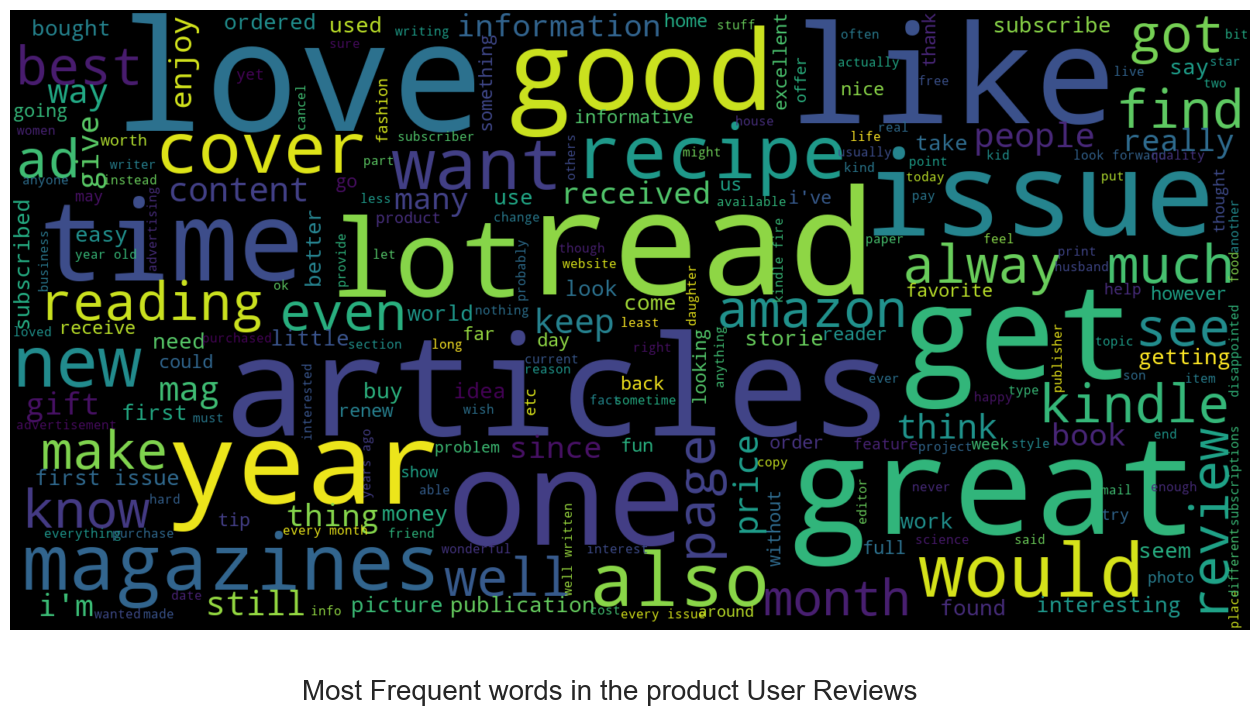

In [44]:
# plot the word cloud
fig = plt.figure(1, figsize=(16, 16))
plt.axis('off')
fig.suptitle("Most Frequent words in the product User Reviews", fontsize=20)
fig.subplots_adjust(top = 2.3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [60]:
LEMMATIZER = WordNetLemmatizer()
df_reviews_mag["tokens"] = df_reviews_mag["reviewText"].apply(preprocess, remove_stop=True, perform_lemm=True)

In [64]:
# scores = sia.polarity_scores(tweet)
# compound, positive, neutral, negative = scores['compound'], scores['pos'], scores['neu'], scores['neg']
compound, pos, neu, neg = [], [], [], []
for review in df_reviews_mag.iterrows():
    tweet_tokens = review[1]["tokens"]
    tweet_text = " ".join(tweet_tokens)
    scores = sia.polarity_scores(tweet_text)
    com, p, nu, ng = scores['compound'], scores['pos'], scores['neu'], scores['neg']
    compound.append(com)
    pos.append(p)
    neu.append(nu)
    neg.append(ng)

In [65]:
df_reviews_mag["V_compound"] = compound
df_reviews_mag["V_pos"] = pos
df_reviews_mag["V_neu"] = neu
df_reviews_mag["V_neg"] = neg

In [67]:
df_reviews_mag["V_Sentiment"] = df_reviews_mag["V_compound"].apply(label_sentiment) 

In [68]:
sample = df_reviews_mag[["reviewText", "V_Sentiment"]].sample(10)
for tweet in sample.iterrows():
    print("Review:", tweet[1].reviewText)
    print("Sentiment: ", tweet[1].V_Sentiment)
    print("#*************#")

Review: Great magazine and good recipes!
Sentiment:  POSITIVE
#*************#
Review: I have been reading Instyle for ages and keep loving it. It's a great fashion/beauty magazine without all the extra trash most other magazines have in them.
Sentiment:  POSITIVE
#*************#
Review: Flipped through nothingness
Sentiment:  NEUTRAL
#*************#
Review: Check the content, especially articles on sex.  I do not want my grandchildren having access to what they think is a teen fashion magazine and I find out it has an article about trying anal sex.  My son has Kindle access for all the kids, I just notified him. Sex education regardless of your views is not a fashion magazine and parents should be advised of content in what is labeled a "teen fashion" magazine. I pay for Prime, I want products reviewed for correct age appropriate content.
Sentiment:  NEUTRAL
#*************#
Review: I'm really enjoying this.  Great recipes!
Sentiment:  POSITIVE
#*************#
Review: I got this subscri

In [69]:
sample = df_reviews_mag[df_reviews_mag["V_Sentiment"] == "NEGATIVE"].sample(10)
for tweet in sample.iterrows():
    print("Review:", tweet[1].reviewText)
    print("Sentiment: ", tweet[1].V_Sentiment)
    print("#*************#")

Review: Great photos and articles.  Always info about what is current and not always about the Kardashians! I am sick to death
Reading about that dysfunctional family.
Sentiment:  NEGATIVE
#*************#
Review: Just nonsense and ads. Every few months they re-review restaurants and where to eat, which they are conveniently stealing from Internet websites/list and just making it their own.

There's no substance, no journalism, no articles worth a grain of salt, just gibberish. What an awful magazine.

Signed, LA native.
Sentiment:  NEGATIVE
#*************#
Review: The publisher sells the mailing list for this newsletter.  My mom is now receiving more junk mail of the type that confuses seniors (asking for money) and has even received scam phone calls. The newsletter is helpful, but I now worry that she will be a victim of a scam.
Sentiment:  NEGATIVE
#*************#
Review: Sadly, I purchased a copy of last months issue, got a confirmation for it to download....not sure what went wrong

In [ ]:
|